In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Anime_UserRatings.csv')
print(f"1. Dataset Shape: {df.shape[0]} rows and {df.shape[1]} columns")

1. Dataset Shape: 862804 rows and 8 columns


In [3]:
print(df.head())

   user_id  anime_id  rating                             genres  \
0      357     28391       6      Drama, School, Sci-Fi, Sports   
1      357       530       6     Demons, Magic, Romance, Shoujo   
2      357     17895       7            Comedy, Romance, Seinen   
3      357     27991       7  Action, Super Power, Supernatural   
4      357     31798       9                      Drama, Sci-Fi   

                          name  average_rating               anime_rating  \
0  Ao no Kanata no Four Rhythm            6.65  PG-13 - Teens 13 or older   
1  Bishoujo Senshi Sailor Moon            7.73  PG-13 - Teens 13 or older   
2                  Golden Time            7.74  PG-13 - Teens 13 or older   
3           K: Return of Kings            7.56  PG-13 - Teens 13 or older   
4                    Kiznaiver            7.38  PG-13 - Teens 13 or older   

                                           image url  
0  https://cdn.myanimelist.net/images/anime/9/778...  
1  https://cdn.myanimeli

In [4]:
print(df.dtypes)

user_id             int64
anime_id            int64
rating              int64
genres             object
name               object
average_rating    float64
anime_rating       object
image url          object
dtype: object


In [5]:
missing_values = df.isnull().sum()
if missing_values.sum() == 0:
    print("No missing values found!")
else:
    print("Missing values per column:")
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            print(f"   - {col}: {df[col].isnull().sum()} missing values")
print()

Missing values per column:
   - genres: 696 missing values



In [6]:
print(df.describe())

            user_id       anime_id         rating  average_rating
count  8.628040e+05  862804.000000  862804.000000   862804.000000
mean   3.547838e+05   11585.702339       7.380351        7.319175
std    3.444441e+05   10657.461558       1.326218        0.620672
min    3.570000e+02       1.000000       5.000000        6.010000
25%    5.866200e+04    2002.000000       6.000000        6.860000
50%    3.308380e+05    8841.000000       7.000000        7.300000
75%    4.779760e+05   18897.000000       8.000000        7.740000
max    1.289699e+06   34525.000000      10.000000        9.100000


In [7]:
df_clean = df.copy()
columns_to_drop = ['average_rating', 'image url']
df_clean = df_clean.drop(columns=columns_to_drop)
print(f"1. Dropped columns: {columns_to_drop}")
print(f"   Remaining columns: {list(df_clean.columns)}")
print()

1. Dropped columns: ['average_rating', 'image url']
   Remaining columns: ['user_id', 'anime_id', 'rating', 'genres', 'name', 'anime_rating']



In [8]:
important_cols = ['user_id', 'anime_id', 'rating', 'name']
missing_important = df_clean[important_cols].isnull().sum().sum()

if missing_important > 0:
    print("2. Found missing values in important columns!")
    # Drop rows where rating is missing (most important for recommendations)
    initial_rows = len(df_clean)
    df_clean = df_clean.dropna(subset=['rating'])
    final_rows = len(df_clean)
    print(f"   Dropped {initial_rows - final_rows} rows with missing ratings")
else:
    print("2. ✓ No missing values in important columns")
print()

2. ✓ No missing values in important columns



In [9]:
# 3. Filter out anime with fewer than 5 ratings
print("3. Filtering anime with at least 5 ratings...")

# Count how many ratings each anime has
anime_rating_counts = df_clean['anime_id'].value_counts()
print(f"   Total unique anime: {len(anime_rating_counts)}")

# Find which anime have 5 or more ratings
popular_anime = anime_rating_counts[anime_rating_counts >= 5].index

# Filter the dataframe
initial_anime_count = df_clean['anime_id'].nunique()
df_clean = df_clean[df_clean['anime_id'].isin(popular_anime)]
final_anime_count = df_clean['anime_id'].nunique()

print(f"   Removed {initial_anime_count - final_anime_count} anime with fewer than 5 ratings")
print(f"   Remaining anime: {final_anime_count}")
print(f"   Remaining rows: {len(df_clean)}")
print()

3. Filtering anime with at least 5 ratings...
   Total unique anime: 6862
   Removed 541 anime with fewer than 5 ratings
   Remaining anime: 6321
   Remaining rows: 861535



In [10]:
print("=== CLEANED DATASET SUMMARY ===")
print(f"Shape: {df_clean.shape[0]} rows, {df_clean.shape[1]} columns")
print(f"Columns: {list(df_clean.columns)}")
print()
print("First 5 rows of cleaned data:")
print(df_clean.head())
print()

=== CLEANED DATASET SUMMARY ===
Shape: 861535 rows, 6 columns
Columns: ['user_id', 'anime_id', 'rating', 'genres', 'name', 'anime_rating']

First 5 rows of cleaned data:
   user_id  anime_id  rating                             genres  \
0      357     28391       6      Drama, School, Sci-Fi, Sports   
1      357       530       6     Demons, Magic, Romance, Shoujo   
2      357     17895       7            Comedy, Romance, Seinen   
3      357     27991       7  Action, Super Power, Supernatural   
4      357     31798       9                      Drama, Sci-Fi   

                          name               anime_rating  
0  Ao no Kanata no Four Rhythm  PG-13 - Teens 13 or older  
1  Bishoujo Senshi Sailor Moon  PG-13 - Teens 13 or older  
2                  Golden Time  PG-13 - Teens 13 or older  
3           K: Return of Kings  PG-13 - Teens 13 or older  
4                    Kiznaiver  PG-13 - Teens 13 or older  



In [11]:
df_clean.to_csv('Test_cleaned.csv', index=False)
print("✓ Cleaned data saved to 'Test_cleaned.csv'")

✓ Cleaned data saved to 'Test_cleaned.csv'


In [12]:
df_prep = df_clean.copy()

# enforce types
df_prep["user_id"]  = df_prep["user_id"].astype(int)
df_prep["anime_id"] = df_prep["anime_id"].astype(int)
df_prep["rating"]   = df_prep["rating"].astype(float)
df_prep["genres"]   = df_prep["genres"].fillna("").astype(str)

# remove duplicates: one rating per (user, anime)
before = len(df_prep)
df_prep = df_prep.drop_duplicates(subset=["user_id", "anime_id"], keep="last").copy()
print(f"1. Removed duplicates: {before - len(df_prep)} rows dropped")

# 2) Process genres (for content-based + hybrid)
df_prep["genres_list"] = df_prep["genres"].apply(
    lambda s: [g.strip() for g in s.split(",") if g.strip()]
)

anime_meta = (
    df_prep[["anime_id", "name", "genres_list"]]
    .drop_duplicates("anime_id")
    .set_index("anime_id")
)

mlb = MultiLabelBinarizer(sparse_output=True)
G = mlb.fit_transform(anime_meta["genres_list"])  # sparse item-feature matrix
genre_names = mlb.classes_.tolist()

print(f"2. Genre features built: items={anime_meta.shape[0]}, genres={len(genre_names)}")

# 3) User-item rating matrix (sparse)
user_ids = df_prep["user_id"].unique()
item_ids = df_prep["anime_id"].unique()

user2idx = {u: k for k, u in enumerate(user_ids)}
item2idx = {a: k for k, a in enumerate(item_ids)}
idx2user = {k: u for u, k in user2idx.items()}
idx2item = {k: a for a, k in item2idx.items()}

u = df_prep["user_id"].map(user2idx).to_numpy()
i = df_prep["anime_id"].map(item2idx).to_numpy()
r = df_prep["rating"].to_numpy(dtype=np.float32)

R = csr_matrix((r, (u, i)), shape=(len(user_ids), len(item_ids)))
print(f"3. User-item matrix built: shape={R.shape}, nnz={R.nnz}")

# 4) Normalize ratings per user (reduces user rating scale bias)
user_mean = df_prep.groupby("user_id")["rating"].transform("mean").astype(np.float32)
user_std  = df_prep.groupby("user_id")["rating"].transform("std").astype(np.float32)

# avoid divide-by-zero for constant raters
user_std = user_std.replace(0, np.nan).fillna(1.0)

df_prep["rating_norm"] = ((df_prep["rating"].astype(np.float32) - user_mean) / user_std).clip(-3, 3)

r_norm = df_prep["rating_norm"].to_numpy(dtype=np.float32)
R_norm = csr_matrix((r_norm, (u, i)), shape=(len(user_ids), len(item_ids)))

print(f"4. Normalized ratings built: R_norm shape={R_norm.shape}, nnz={R_norm.nnz}")

1. Removed duplicates: 0 rows dropped
2. Genre features built: items=6321, genres=43
3. User-item matrix built: shape=(813, 6321), nnz=861535
4. Normalized ratings built: R_norm shape=(813, 6321), nnz=861535


=== VISUALIZING DATA PATTERNS ===
genre_list exists: True
example: ['Drama', 'School', 'Sci-Fi', 'Sports']
1. Creating Rating Distribution plot...
   - Mean rating: 7.38/10
   - Median rating: 7.0/10
   - Rating range: 5.0 to 10.0

2. Creating Ratings per User plot...
   - Total users: 813
   - Average ratings per user: 1059.7
   - Most active user: 1230323 with 2212 ratings

3. Creating Genre Popularity plot...
   - Total unique genres: 43
   - Top 3 genres: Comedy, Action, Romance
   - Most common genre 'Comedy' appears in 423945 anime

4. Creating Ratings by Genre plot...
   - Highest rated genre: 'Mystery' (7.6/10)
   - Lowest rated in top 10: 'Sci-Fi' (7.4/10)
   - 10 genres rated above average



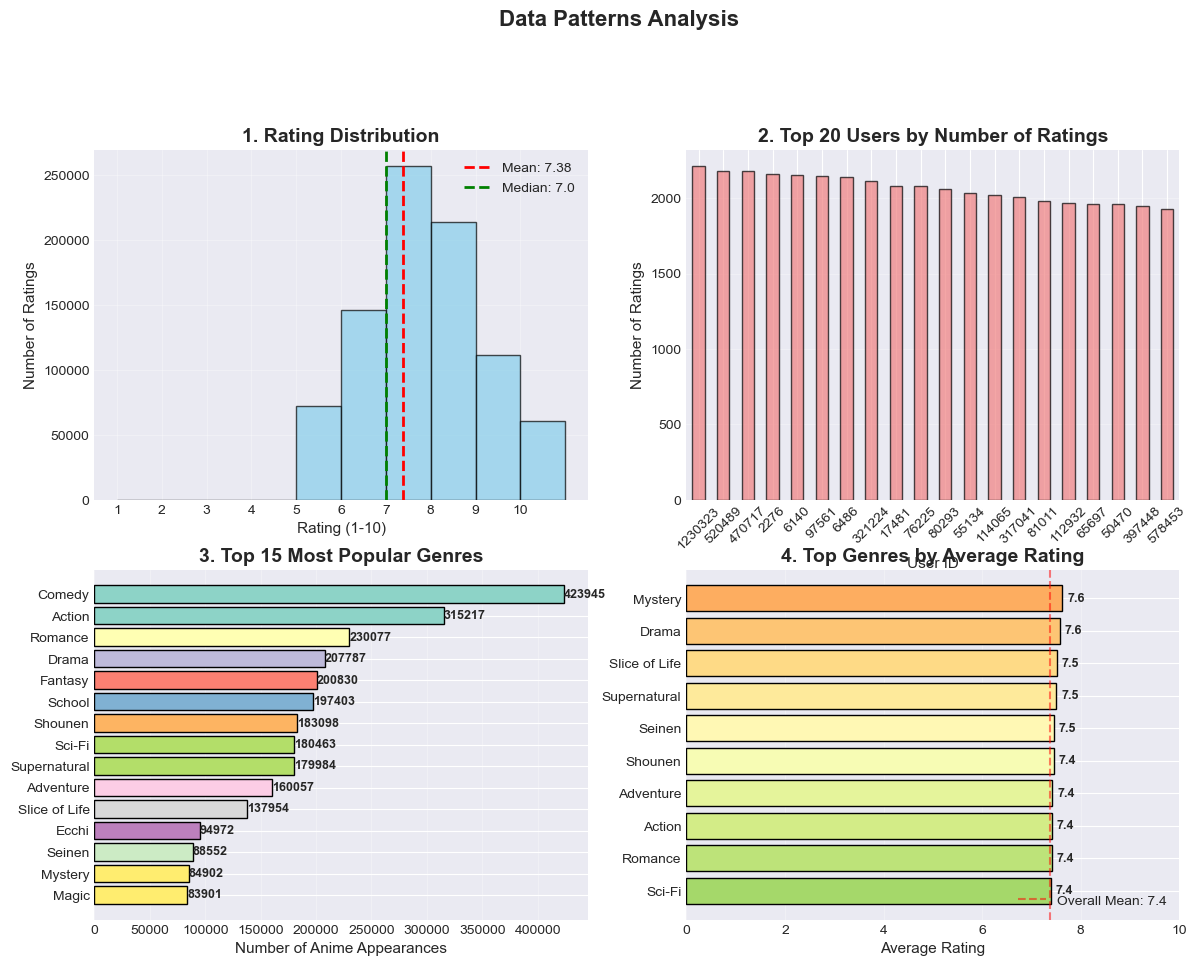

In [13]:
# ===============================
# f) Visualize Data Patterns (Concise Version)
# ===============================

print("=== VISUALIZING DATA PATTERNS ===")
df_prep["user_id"]  = df_prep["user_id"].astype(int)
df_prep["anime_id"] = df_prep["anime_id"].astype(int)
df_prep["rating"]   = df_prep["rating"].astype(float)

# CSV column is 'genres' (not 'genre_list')
df_prep["genres"] = df_prep["genres"].fillna("").astype(str)

# Create the exact column your plots expect
df_prep["genre_list"] = df_prep["genres"].apply(
    lambda s: [g.strip() for g in s.split(",") if g.strip()]
)

# sanity check
print("genre_list exists:", "genre_list" in df_prep.columns)
print("example:", df_prep["genre_list"].iloc[0])

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Data Patterns Analysis', fontsize=16, fontweight='bold', y=1.02)

# ========== 1. Rating Distribution ==========
print("1. Creating Rating Distribution plot...")
ax1 = axes[0, 0]

# Get all ratings
all_ratings = df_prep['rating']

# Create histogram
n, bins, patches = ax1.hist(all_ratings, bins=range(1, 12), 
                           edgecolor='black', alpha=0.7, color='skyblue')

ax1.set_title('1. Rating Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Rating (1-10)', fontsize=11)
ax1.set_ylabel('Number of Ratings', fontsize=11)
ax1.set_xticks(range(1, 11))
ax1.grid(True, alpha=0.3)

# Add statistics
mean_rating = all_ratings.mean()
median_rating = all_ratings.median()
ax1.axvline(mean_rating, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_rating:.2f}')
ax1.axvline(median_rating, color='green', linestyle='--', linewidth=2, label=f'Median: {median_rating}')
ax1.legend()

print(f"   - Mean rating: {mean_rating:.2f}/10")
print(f"   - Median rating: {median_rating}/10")
print(f"   - Rating range: {all_ratings.min()} to {all_ratings.max()}")
print()

# ========== 2. Number of Ratings per User ==========
print("2. Creating Ratings per User plot...")
ax2 = axes[0, 1]

# Count ratings per user
ratings_per_user = df_prep['user_id'].value_counts()

# Since we only have 1 user in this sample dataset
if len(ratings_per_user) == 1:
    # Single user case
    user_id = ratings_per_user.index[0]
    count = ratings_per_user.values[0]
    
    ax2.bar([str(user_id)], [count], color='lightcoral', alpha=0.7, edgecolor='black')
    ax2.set_title(f'2. Ratings for User {user_id}', fontsize=14, fontweight='bold')
    ax2.set_xlabel('User ID', fontsize=11)
    ax2.set_ylabel('Number of Ratings', fontsize=11)
    ax2.text(0, count/2, f'{count} ratings', ha='center', va='center', fontsize=12, fontweight='bold')
    
    print(f"   - User {user_id} has {count} ratings")
    
else:
    # Multiple users case
    ratings_per_user.head(20).plot(kind='bar', ax=ax2, color='lightcoral', alpha=0.7, edgecolor='black')
    ax2.set_title('2. Top 20 Users by Number of Ratings', fontsize=14, fontweight='bold')
    ax2.set_xlabel('User ID', fontsize=11)
    ax2.set_ylabel('Number of Ratings', fontsize=11)
    ax2.tick_params(axis='x', rotation=45)
    
    print(f"   - Total users: {len(ratings_per_user)}")
    print(f"   - Average ratings per user: {ratings_per_user.mean():.1f}")
    print(f"   - Most active user: {ratings_per_user.index[0]} with {ratings_per_user.values[0]} ratings")

ax2.grid(True, alpha=0.3, axis='y')
print()

# ========== 3. Genre Popularity ==========
print("3. Creating Genre Popularity plot...")
ax3 = axes[1, 0]

all_genres = [g for sub in df_prep["genre_list"] for g in sub]
genre_counts = pd.Series(all_genres).value_counts()

top_genres = genre_counts.head(15)
colors = plt.cm.Set3(np.linspace(0, 1, len(top_genres)))

bars = ax3.barh(range(len(top_genres)), top_genres.values, color=colors, edgecolor='black')
ax3.set_yticks(range(len(top_genres)))
ax3.set_yticklabels(top_genres.index, fontsize=10)
ax3.set_title('3. Top 15 Most Popular Genres', fontsize=14, fontweight='bold')
ax3.set_xlabel('Number of Anime Appearances', fontsize=11)
ax3.invert_yaxis()
ax3.grid(True, alpha=0.3, axis='x')

for bar, count in zip(bars, top_genres.values):
    ax3.text(count + 0.5, bar.get_y() + bar.get_height()/2, f'{count}', va='center', fontsize=9, fontweight='bold')

print(f"   - Total unique genres: {len(genre_counts)}")
print(f"   - Top 3 genres: {top_genres.index[0]}, {top_genres.index[1]}, {top_genres.index[2]}")
print(f"   - Most common genre '{top_genres.index[0]}' appears in {top_genres.values[0]} anime")
print()

# ========== 4. Ratings by Genre ==========
print("4. Creating Ratings by Genre plot...")
ax4 = axes[1, 1]

genre_avg_ratings = {}
for genre in top_genres.index:
    genre_mask = df_prep["genre_list"].apply(lambda lst: genre in lst)
    if genre_mask.sum() >= 2:
        genre_avg_ratings[genre] = df_prep.loc[genre_mask, "rating"].mean()

genre_avg_series = pd.Series(genre_avg_ratings).sort_values(ascending=False)

top_rated_genres = genre_avg_series.head(10)
colors = plt.cm.RdYlGn(np.linspace(0.3, 0.7, len(top_rated_genres)))

bars = ax4.barh(range(len(top_rated_genres)), top_rated_genres.values, color=colors, edgecolor='black')
ax4.set_yticks(range(len(top_rated_genres)))
ax4.set_yticklabels(top_rated_genres.index, fontsize=10)
ax4.set_title('4. Top Genres by Average Rating', fontsize=14, fontweight='bold')
ax4.set_xlabel('Average Rating', fontsize=11)
ax4.set_xlim([0, 10])
ax4.axvline(x=mean_rating, color='red', linestyle='--', alpha=0.5, label=f'Overall Mean: {mean_rating:.1f}')
ax4.invert_yaxis()
ax4.legend(loc='lower right')
ax4.grid(True, alpha=0.3, axis='x')

for bar, rating in zip(bars, top_rated_genres.values):
    ax4.text(rating + 0.1, bar.get_y() + bar.get_height()/2, f'{rating:.1f}', va='center', fontsize=9, fontweight='bold')

print(f"   - Highest rated genre: '{top_rated_genres.index[0]}' ({top_rated_genres.values[0]:.1f}/10)")
print(f"   - Lowest rated in top 10: '{top_rated_genres.index[-1]}' ({top_rated_genres.values[-1]:.1f}/10)")
print(f"   - {sum(top_rated_genres.values > mean_rating)} genres rated above average")
print()

In [14]:
df_split = df_prep.copy()

# If you have a timestamp column, use it for a realistic split
if "timestamp" in df_split.columns:
    df_split = df_split.sort_values(["user_id", "timestamp"])
else:
    df_split = df_split.sort_values(["user_id", "anime_id"])

train_parts = []
test_parts = []

for uid, group in df_split.groupby("user_id"):
    if len(group) < 2:
        continue  # cannot split a user with 1 interaction
    
    train_u, test_u = train_test_split(group, test_size=0.2, random_state=42)
    train_parts.append(train_u)
    test_parts.append(test_u)

train_df = pd.concat(train_parts).reset_index(drop=True)
test_df  = pd.concat(test_parts).reset_index(drop=True)

print("Train size:", train_df.shape)
print("Test size :", test_df.shape)
print("Users in train:", train_df["user_id"].nunique())
print("Users in test :", test_df["user_id"].nunique())

# 1) Every user in test must also exist in train
assert set(test_df["user_id"]).issubset(set(train_df["user_id"]))

# 2) Remove cold-start items from test (items not seen in training)
train_items = set(train_df["anime_id"].unique())
test_df = test_df[test_df["anime_id"].isin(train_items)].copy()

print("Final Test size after removing cold-start items:", test_df.shape)

Train size: (688898, 9)
Test size : (172637, 9)
Users in train: 813
Users in test : 813
Final Test size after removing cold-start items: (172637, 9)


In [15]:
# 0) Safe merge (only if you need name/genres in train_df/test_df for display)
TOPK_SIM = 50
TOPN_REC = 10
ALPHA = 0.6

anime_meta = df_prep[["anime_id", "name", "genres"]].drop_duplicates("anime_id")
train_df = train_df.drop(columns=["name","genres"], errors="ignore").merge(anime_meta, on="anime_id", how="left")
test_df  = test_df.drop(columns=["name","genres"], errors="ignore").merge(anime_meta, on="anime_id", how="left")

# 1) TRAIN-only vocab (prevents leakage)
train_users = train_df["user_id"].unique()
train_items = train_df["anime_id"].unique()

user2idx = {u:i for i,u in enumerate(train_users)}
item2idx = {a:i for i,a in enumerate(train_items)}
idx2item = {i:a for a,i in item2idx.items()}

# 2) TRAIN user-item matrix
u = train_df["user_id"].map(user2idx).to_numpy()
i = train_df["anime_id"].map(item2idx).to_numpy()
r = train_df["rating"].to_numpy(dtype=np.float32)

R_train = csr_matrix((r, (u, i)), shape=(len(train_users), len(train_items)))

# 3) TRAIN item-genre matrix aligned to item2idx
train_item_meta = anime_meta[anime_meta["anime_id"].isin(train_items)].copy()
train_item_meta["genres"] = train_item_meta["genres"].fillna("").astype(str)
train_item_meta["genre_list"] = train_item_meta["genres"].str.split(",").apply(
    lambda xs: [x.strip() for x in xs if x.strip()]
)

train_item_meta["item_idx"] = train_item_meta["anime_id"].map(item2idx)
train_item_meta = train_item_meta.dropna(subset=["item_idx"]).sort_values("item_idx")

mlb = MultiLabelBinarizer(sparse_output=True)
G_items = mlb.fit_transform(train_item_meta["genre_list"])  # (n_items x n_genres)

itemidx2name = train_item_meta.set_index("item_idx")["name"].fillna("Unknown").to_dict()

print("Initialized:")
print("R_train:", R_train.shape, "nnz:", R_train.nnz)
print("G_items:", G_items.shape)
print("Users:", len(train_users), "Items:", len(train_items))

Initialized:
R_train: (813, 6321) nnz: 688898
G_items: (6321, 43)
Users: 813 Items: 6321


In [17]:
def recommend_content(user_id, n=TOPN_REC):
    if user_id not in user2idx:
        return pd.DataFrame(columns=["anime_id","name","score"])

    uid = user2idx[user_id]
    user_row = R_train.getrow(uid)
    seen_item_idxs = set(user_row.indices.tolist())

    # user preference vector over genres = sum(rating * genre_vector)
    ratings = user_row.data
    items   = user_row.indices
    if len(items) == 0:
        return pd.DataFrame(columns=["anime_id","name","score"])

    user_pref = (G_items[items].multiply(ratings.reshape(-1, 1))).sum(axis=0)  # 1 x n_genres
    
    # FIX: Convert to array for dot product
    user_pref_array = user_pref.A1  # Convert to 1D array

    # Calculate cosine similarity: (A·B)/(|A||B|)
    pref_norm = np.linalg.norm(user_pref_array) + 1e-9
    item_norm = np.sqrt(G_items.multiply(G_items).sum(axis=1)).A1 + 1e-9
    dot = G_items.dot(user_pref_array)  # This gives a 1D array directly
    
    scores = dot / (item_norm * pref_norm)

    # remove seen
    if seen_item_idxs:
        scores[list(seen_item_idxs)] = -np.inf

    top_idx = np.argpartition(-scores, range(min(n, len(scores))))[:min(n, len(scores))]
    top_idx = top_idx[np.argsort(-scores[top_idx])]

    out = pd.DataFrame({
        "anime_id": [idx2item[j] for j in top_idx],
        "name": [itemidx2name.get(j, "Unknown") for j in top_idx],
        "score": scores[top_idx]
    })
    return out

In [18]:
n_components = 50
svd = TruncatedSVD(n_components=n_components, random_state=42)
user_factors = svd.fit_transform(R_train)  # shape: (n_users, n_components)
item_factors = svd.components_.T           # shape: (n_items, n_components)

print(f"User factors shape: {user_factors.shape}")
print(f"Item factors shape: {item_factors.shape}")

def recommend_collab(user_id, n=TOPN_REC):
    """
    Pure SVD-based collaborative filtering
    Predict rating = user_factor • item_factor^T
    """
    if user_id not in user2idx:
        return pd.DataFrame(columns=["anime_id","name","score"])
    
    uid = user2idx[user_id]
    
    # User's latent vector
    u_vec = user_factors[uid]  # shape: (n_components,)
    
    # Predicted ratings for all items: u_vec • item_factors^T
    scores = item_factors.dot(u_vec)  # shape: (n_items,)
    
    # Remove items user already rated
    user_row = R_train.getrow(uid)
    seen = set(user_row.indices)
    scores[list(seen)] = -np.inf
    
    # Get top n
    top_idx = np.argsort(-scores)[:n]
    
    return pd.DataFrame({
        "anime_id": [idx2item[i] for i in top_idx],
        "name": [itemidx2name.get(i, "Unknown") for i in top_idx],
        "score": scores[top_idx]
    })

User factors shape: (813, 50)
Item factors shape: (6321, 50)


In [19]:
def recommend_hybrid(user_id, n=TOPN_REC, alpha=0.85, beta=0.15):
    """
    CORRECT hybrid formula: Final_Score = α × CF_Score + β × CB_Score
    Where α + β = 1.0 (or close to it)
    """
    # Get raw scores from both models
    cf_df = recommend_collab(user_id, n=TOPK_SIM * 3)
    cb_df = recommend_content(user_id, n=TOPK_SIM * 3)
    
    if cf_df.empty and cb_df.empty:
        return pd.DataFrame(columns=["anime_id","name","score"])
    
    # Combine using dictionary for O(1) lookups
    scores = {}
    
    # Add collaborative scores with weight α
    for _, row in cf_df.iterrows():
        aid = row['anime_id']
        scores[aid] = scores.get(aid, 0.0) + alpha * row['score']
    
    # Add content scores with weight β  
    for _, row in cb_df.iterrows():
        aid = row['anime_id']
        scores[aid] = scores.get(aid, 0.0) + beta * row['score']
    
    # Convert to DataFrame and sort
    result = pd.DataFrame([
        {"anime_id": aid, "score": score}
        for aid, score in sorted(scores.items(), key=lambda x: x[1], reverse=True)[:n]
    ])
    
    # Add names
    result["name"] = result["anime_id"].apply(
        lambda aid: itemidx2name.get(item2idx.get(aid, -1), "Unknown")
    )
    
    return result[["anime_id", "name", "score"]]

In [20]:
example_user = train_df["user_id"].iloc[0]

print("CONTENT-BASED")
display(recommend_content(example_user, n=10))

print("COLLABORATIVE")
display(recommend_collab(example_user, n=10))

print("HYBRID")
display(recommend_hybrid(example_user, n=10))

CONTENT-BASED


,anime_id,name,score
0,231,Asagiri no Miko,0.794724
1,6489,Zero no Tsukaima: Princesses no Rondo Picture ...,0.791757
2,24705,"Ore, Twintail ni Narimasu.",0.788776
3,31716,Rewrite,0.775357
4,31845,Masou Gakuen HxH,0.771979
5,16001,Kokoro Connect: Michi Random,0.762085
6,20517,Little Busters! EX,0.762085
7,1327,Aoki Densetsu Shoot!,0.759709
8,6567,Urusei Yatsura: The Shougaibutsu Suieitaikai,0.759214
9,10460,Kimi to Boku.,0.754867


COLLABORATIVE


,anime_id,name,score
0,5680,K-On!,7.723956
1,28907,"Gate: Jieitai Kanochi nite, Kaku Tatakaeri",7.343050
2,2966,Ookami to Koushinryou,7.258520
3,1887,Lucky☆Star,6.919555
4,1,Cowboy Bebop,6.809335
5,31240,Re:Zero kara Hajimeru Isekai Seikatsu,6.493382
6,9756,Mahou Shoujo Madoka★Magica,6.409299
7,30831,Kono Subarashii Sekai ni Shukufuku wo!,6.358674
8,31859,Hai to Gensou no Grimgar,6.154017
9,5341,Ookami to Koushinryou II,6.019706


HYBRID


,anime_id,name,score
0,5680,K-On!,6.565363
1,28907,"Gate: Jieitai Kanochi nite, Kaku Tatakaeri",6.241593
2,2966,Ookami to Koushinryou,6.169742
3,1887,Lucky☆Star,5.881622
4,1,Cowboy Bebop,5.787935
5,31240,Re:Zero kara Hajimeru Isekai Seikatsu,5.519375
6,9756,Mahou Shoujo Madoka★Magica,5.447904
7,30831,Kono Subarashii Sekai ni Shukufuku wo!,5.404873
8,31859,Hai to Gensou no Grimgar,5.230914
9,5341,Ookami to Koushinryou II,5.116750


In [21]:
K = 10
RELEVANT_THRESHOLD = 7.0  # treat rating >= 7 as "liked"

def get_relevant_items(test_df, threshold=RELEVANT_THRESHOLD):
    rel = test_df[test_df["rating"] >= threshold]
    return rel.groupby("user_id")["anime_id"].apply(set).to_dict()

relevant_items = get_relevant_items(test_df)

def precision_recall_at_k(recommended, relevant, k=K):
    if len(recommended) == 0:
        return 0.0, 0.0

    recommended_k = recommended[:k]
    hits = len(set(recommended_k) & relevant)

    precision = hits / k
    recall = hits / len(relevant) if len(relevant) > 0 else 0.0
    return precision, recall

def evaluate_model(recommend_func, test_df, k=K, verbose=False):
    """
    CORRECT evaluation that:
    1. Only considers items that CAN be recommended (in training)
    2. Includes ALL test users (even those with no recommendations)
    3. Properly handles ID mappings
    """
    precisions = []
    recalls = []
    users_evaluated = 0
    users_with_no_recs = 0
    users_with_no_relevant_in_train = 0
    
    # Get training items (items that CAN be recommended)
    train_items_set = set(train_df['anime_id'].unique())
    
    for user_id, rel_set in relevant_items.items():
        if len(rel_set) == 0:
            continue
            
        # Filter relevant items to ONLY those in training
        rel_set_in_train = {aid for aid in rel_set if aid in train_items_set}
        
        if len(rel_set_in_train) == 0:
            users_with_no_relevant_in_train += 1
            if verbose:
                print(f"User {user_id}: No relevant items in training vocabulary")
            continue
            
        # Get recommendations
        recs = recommend_func(user_id, k)
        
        # Handle empty recommendations (count as zeros)
        if recs is None or len(recs) == 0:
            users_with_no_recs += 1
            precisions.append(0.0)
            recalls.append(0.0)
            users_evaluated += 1
            continue
        
        # Extract anime_ids from recommendations
        if isinstance(recs, pd.DataFrame):
            if 'anime_id' in recs.columns:
                rec_list = recs['anime_id'].head(k).tolist()
            else:
                raise ValueError("Recommendation DataFrame missing 'anime_id' column")
        else:
            rec_list = list(recs)[:k]
        
        # Calculate hits (only considering items in training)
        hits = len(set(rec_list) & rel_set_in_train)
        
        # Calculate metrics
        precision = hits / k
        recall = hits / len(rel_set_in_train)
        
        precisions.append(precision)
        recalls.append(recall)
        users_evaluated += 1
        
        if verbose and hits == 0:
            print(f"User {user_id}: 0 hits. Relevant: {len(rel_set_in_train)} items")
    
    # Calculate final metrics
    avg_precision = np.mean(precisions) if precisions else 0.0
    avg_recall = np.mean(recalls) if recalls else 0.0
    
    print(f"\nEvaluation Summary:")
    print(f"- Total users with relevant items: {len(relevant_items)}")
    print(f"- Users evaluated: {users_evaluated}")
    print(f"- Users with no recommendations: {users_with_no_recs}")
    print(f"- Users with no relevant items in training: {users_with_no_relevant_in_train}")
    print(f"- Average Precision@{k}: {avg_precision:.4f}")
    print(f"- Average Recall@{k}: {avg_recall:.4f}")
    
    return {
        "Users Evaluated": users_evaluated,
        "Precision@K": float(avg_precision),
        "Recall@K": float(avg_recall),
        "Users_No_Recommendations": users_with_no_recs,
        "Users_No_Relevant_In_Train": users_with_no_relevant_in_train
    }

In [22]:

results = []

results.append({"Model": "Content-Based", **evaluate_model(recommend_content, test_df, k=K)})
results.append({"Model": "Collaborative", **evaluate_model(recommend_collab, test_df, k=K)})
results.append({"Model": "Hybrid", **evaluate_model(recommend_hybrid, test_df, k=K)})

results_df = pd.DataFrame(results)
results_df


Evaluation Summary:
- Total users with relevant items: 813
- Users evaluated: 813
- Users with no recommendations: 0
- Users with no relevant items in training: 0
- Average Precision@10: 0.1017
- Average Recall@10: 0.0066

Evaluation Summary:
- Total users with relevant items: 813
- Users evaluated: 813
- Users with no recommendations: 0
- Users with no relevant items in training: 0
- Average Precision@10: 0.7882
- Average Recall@10: 0.0546

Evaluation Summary:
- Total users with relevant items: 813
- Users evaluated: 813
- Users with no recommendations: 0
- Users with no relevant items in training: 0
- Average Precision@10: 0.7873
- Average Recall@10: 0.0545


,Model,Users Evaluated,Precision@K,Recall@K,Users_No_Recommendations,Users_No_Relevant_In_Train
0,Content-Based,813,0.101722,0.006588,0,0
1,Collaborative,813,0.788192,0.054592,0,0
2,Hybrid,813,0.787331,0.054490,0,0


In [23]:
print("=== CORRECT EVALUATION ===")

models = [
    ("Content-Based", recommend_content),
    ("SVD Collaborative", recommend_collab),
    ("Hybrid", lambda uid, k=10: recommend_hybrid(uid, n=k, alpha=0.89, beta=0.11))
]

for name, func in models:
    print(f"\n{name}:")
    metrics = evaluate_model(func, test_df, k=10, verbose=False)
    print(metrics)

=== CORRECT EVALUATION ===

Content-Based:

Evaluation Summary:
- Total users with relevant items: 813
- Users evaluated: 813
- Users with no recommendations: 0
- Users with no relevant items in training: 0
- Average Precision@10: 0.1017
- Average Recall@10: 0.0066
{'Users Evaluated': 813, 'Precision@K': 0.10172201722017221, 'Recall@K': 0.006587834944781985, 'Users_No_Recommendations': 0, 'Users_No_Relevant_In_Train': 0}

SVD Collaborative:

Evaluation Summary:
- Total users with relevant items: 813
- Users evaluated: 813
- Users with no recommendations: 0
- Users with no relevant items in training: 0
- Average Precision@10: 0.7882
- Average Recall@10: 0.0546
{'Users Evaluated': 813, 'Precision@K': 0.7881918819188193, 'Recall@K': 0.05459150253530864, 'Users_No_Recommendations': 0, 'Users_No_Relevant_In_Train': 0}

Hybrid:

Evaluation Summary:
- Total users with relevant items: 813
- Users evaluated: 813
- Users with no recommendations: 0
- Users with no relevant items in training: 0
- 

In [24]:
rand_user = int(np.random.choice(train_df["user_id"].unique()))
print("Random user_id:", rand_user)

print("\nSVD Collaborative (Top 10):")
display(recommend_collab(rand_user, n=10))

print("\nContent-Based (Top 10):")
display(recommend_content(rand_user, n=10))

print("\nHybrid (Top 10):")
display(recommend_hybrid(rand_user, n=10, alpha=0.6))

Random user_id: 306033

SVD Collaborative (Top 10):


,anime_id,name,score
0,10020,Ore no Imouto ga Konnani Kawaii Wake ga Nai Sp...,9.267708
1,9379,Denpa Onna to Seishun Otoko,9.153031
2,17082,Aiura,8.772211
3,9253,Steins;Gate,8.687007
4,19815,No Game No Life,8.630702
5,10357,Jinrui wa Suitai Shimashita,8.402534
6,11981,Mahou Shoujo Madoka★Magica Movie 3: Hangyaku n...,8.234133
7,20047,Sakura Trick,8.095400
8,14829,Fate/kaleid liner Prisma☆Illya,8.077965
9,14349,Little Witch Academia,8.051825



Content-Based (Top 10):


,anime_id,name,score
0,231,Asagiri no Miko,0.787119
1,16001,Kokoro Connect: Michi Random,0.775830
2,31716,Rewrite,0.762918
3,18671,Chuunibyou demo Koi ga Shitai! Ren,0.754664
4,509,I My Me! Strawberry Eggs,0.754664
5,27601,Chuunibyou demo Koi ga Shitai! Ren: The Rikka ...,0.754664
6,6567,Urusei Yatsura: The Shougaibutsu Suieitaikai,0.750237
7,10460,Kimi to Boku.,0.748980
8,11739,Kimi to Boku. 2,0.748980
9,2564,Code-E,0.741534



Hybrid (Top 10):


,anime_id,name,score
0,10020,Ore no Imouto ga Konnani Kawaii Wake ga Nai Sp...,5.560625
1,9379,Denpa Onna to Seishun Otoko,5.491819
2,17082,Aiura,5.365829
3,9253,Steins;Gate,5.212204
4,19815,No Game No Life,5.178421
5,10357,Jinrui wa Suitai Shimashita,5.041521
6,11981,Mahou Shoujo Madoka★Magica Movie 3: Hangyaku n...,4.940480
7,19221,"Ore no Nounai Sentakushi ga, Gakuen Love Comed...",4.932012
8,20047,Sakura Trick,4.857240
9,14829,Fate/kaleid liner Prisma☆Illya,4.846779


In [25]:
def recommend_new_user_interactive(n=10):
    # 1) Ask genres
    genres_in_data = sorted({g for gl in df_prep["genre_list"] for g in gl})
    print("Enter genres you like (comma-separated). Examples:")
    print(", ".join(genres_in_data[:25]), "...")
    liked_genres = input("Liked genres: ").strip()

    preferred_genres = {g.strip() for g in liked_genres.split(",") if g.strip()}
    if not preferred_genres:
        raise ValueError("No genres provided.")

    # 2) Ask liked anime (optional)
    liked_anime = input("Enter 3 anime you like (comma-separated, optional): ").strip()
    liked_titles = {t.strip().lower() for t in liked_anime.split(",") if t.strip()}

    # 3) Ask disliked anime (optional)
    disliked_anime = input("Enter 1–2 anime you dislike (comma-separated, optional): ").strip()
    disliked_titles = {t.strip().lower() for t in disliked_anime.split(",") if t.strip()}

    # Candidate anime (one row per anime)
    anime = df_prep[["anime_id","name","genre_list","rating"]].drop_duplicates("anime_id").copy()

    # match genres
    anime["match_count"] = anime["genre_list"].apply(lambda gl: len(preferred_genres & set(gl)))

    # remove non-matching
    anime = anime[anime["match_count"] > 0].copy()

    # down-rank disliked titles (simple string contains)
    if disliked_titles:
        anime["disliked"] = anime["name"].str.lower().apply(lambda nm: any(t in nm for t in disliked_titles))
        anime = anime[~anime["disliked"]].copy()

    # remove liked titles from recommendations (don’t recommend what they already like)
    if liked_titles:
        anime["liked"] = anime["name"].str.lower().apply(lambda nm: any(t in nm for t in liked_titles))
        anime = anime[~anime["liked"]].copy()

    # rank: genre match first, then rating
    anime = anime.sort_values(["match_count","rating"], ascending=[False, False])

    return anime[["anime_id","name","match_count","rating"]].head(n)


In [26]:
display(recommend_new_user_interactive(n=10))

Enter genres you like (comma-separated). Examples:
Action, Adventure, Cars, Comedy, Dementia, Demons, Drama, Ecchi, Fantasy, Game, Harem, Hentai, Historical, Horror, Josei, Kids, Magic, Martial Arts, Mecha, Military, Music, Mystery, Parody, Police, Psychological ...


,anime_id,name,match_count,rating
1165,1,Cowboy Bebop,3,10.0
35287,6714,Dragon Ball Z: Atsumare! Gokuu World,3,10.0
1518,6811,InuYasha: Kanketsu-hen,3,9.0
1698,6115,Lupin III vs. Detective Conan,3,9.0
1905,527,Pokemon,3,9.0
1914,1565,Pokemon Diamond & Pearl,3,9.0
2046,205,Samurai Champloo,3,9.0
9319,1249,"Zone of the Enders: Dolores, I",3,9.0
10394,808,Bakuretsu Hunters OVA,3,9.0
19716,11777,Lupin III: Chi no Kokuin - Eien no Mermaid,3,9.0


In [28]:
def user_report(user_id, top_rated_n=3, rec_n=5):
    print(f"\nQuick test for User {user_id}:")
    print("-"*40)

    # user history from TRAIN
    user_hist = train_df[train_df["user_id"] == user_id].copy()
    if user_hist.empty:
        print("User not found in training data.")
        return

    # favorite genres (from their watched anime)
    fav_genres = (
        user_hist["genres"]
        .fillna("")
        .astype(str)
        .str.split(",")
        .explode()
        .str.strip()
    )
    fav_genres = fav_genres[fav_genres != ""].value_counts().head(3).index.tolist()

    print("Favorite genres:", ", ".join(fav_genres) if fav_genres else "Unknown")

    # top rated anime by this user
    top_rated = user_hist.sort_values("rating", ascending=False).head(top_rated_n)
    print("Top rated anime:")
    for _, row in top_rated.iterrows():
        print(f"  - {row['name']} ({row['rating']:.0f}/10)")

    # helper to print recs
    def show_recs(title, rec_df):
        print(f"\n{title} Recommendations:")
        for idx, row in rec_df.head(rec_n).iterrows():
            aid = row["anime_id"]
            meta = df_prep[df_prep["anime_id"] == aid].iloc[0]
            g = ", ".join(meta["genre_list"]) if "genre_list" in meta else str(meta.get("genres",""))
            avg = df_prep[df_prep["anime_id"] == aid]["rating"].mean()
            print(f"{(rec_df.index.get_loc(idx)+1)}. {row['name']}")
            print(f"   Genres: {g}, Avg Rating: {avg:.1f}")

    # Content
    show_recs("Content-Based", recommend_content(user_id, n=10))

    # Collaborative (SVD)
    show_recs("Collaborative (SVD)", recommend_collab(user_id, n=10))

    # Hybrid
    show_recs("Hybrid", recommend_hybrid(user_id, n=10, alpha=0.6))


# Example: pick one of your sample users
user_report(86383)



Quick test for User 86383:
----------------------------------------
Favorite genres: Comedy, Action, School
Top rated anime:
  - Nagasarete Airantou (10/10)
  - Senyuu. (9/10)
  - The iDOLM@STER (9/10)

Content-Based Recommendations:
1. Rewrite
   Genres: Action, Comedy, Romance, School, Supernatural, Avg Rating: 6.7
2. Ore, Twintail ni Narimasu.
   Genres: Action, Comedy, Fantasy, Romance, School, Shounen, Avg Rating: 6.8
3. Trinity Seven Movie 1: Eternity Library to Alchemic Girl
   Genres: Action, Comedy, Ecchi, Fantasy, Harem, Magic, Romance, School, Shounen, Avg Rating: 6.8
4. Asagiri no Miko
   Genres: Action, Comedy, Drama, Fantasy, Magic, School, Sci-Fi, Shounen, Slice of Life, Super Power, Supernatural, Avg Rating: 6.6
5. Zero no Tsukaima: Princesses no Rondo Picture Drama
   Genres: Action, Adventure, Comedy, Drama, Ecchi, Fantasy, Harem, Magic, Romance, School, Avg Rating: 6.7

Collaborative (SVD) Recommendations:
1. Baka to Test to Shoukanjuu
   Genres: Comedy, Romance, Sc

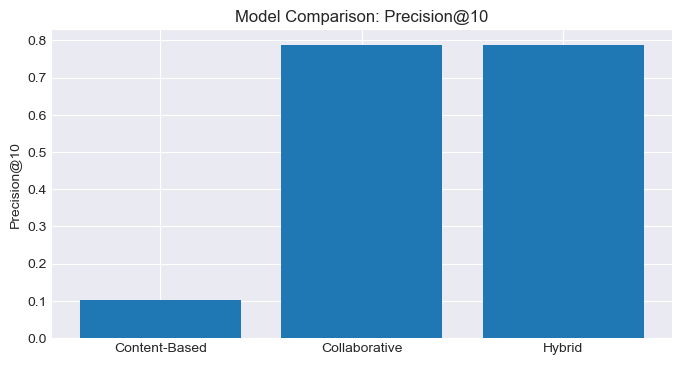

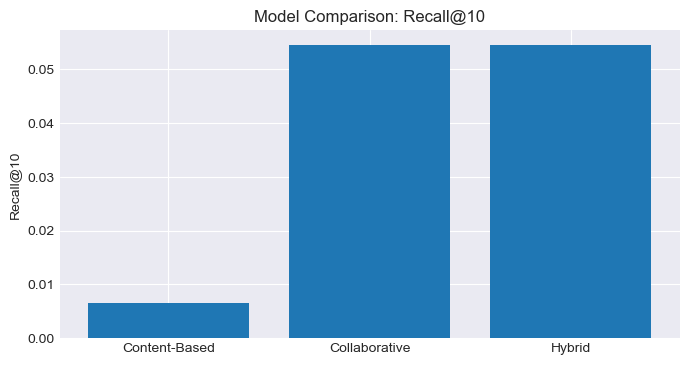

In [29]:
plot_df = results_df.copy()
plot_df = plot_df.rename(columns={"Precision@K":"Precision@10", "Recall@K":"Recall@10"})

plt.figure(figsize=(8,4))
plt.bar(plot_df["Model"], plot_df["Precision@10"])
plt.title("Model Comparison: Precision@10")
plt.ylabel("Precision@10")
plt.xticks(rotation=0)
plt.show()

plt.figure(figsize=(8,4))
plt.bar(plot_df["Model"], plot_df["Recall@10"])
plt.title("Model Comparison: Recall@10")
plt.ylabel("Recall@10")
plt.xticks(rotation=0)
plt.show()

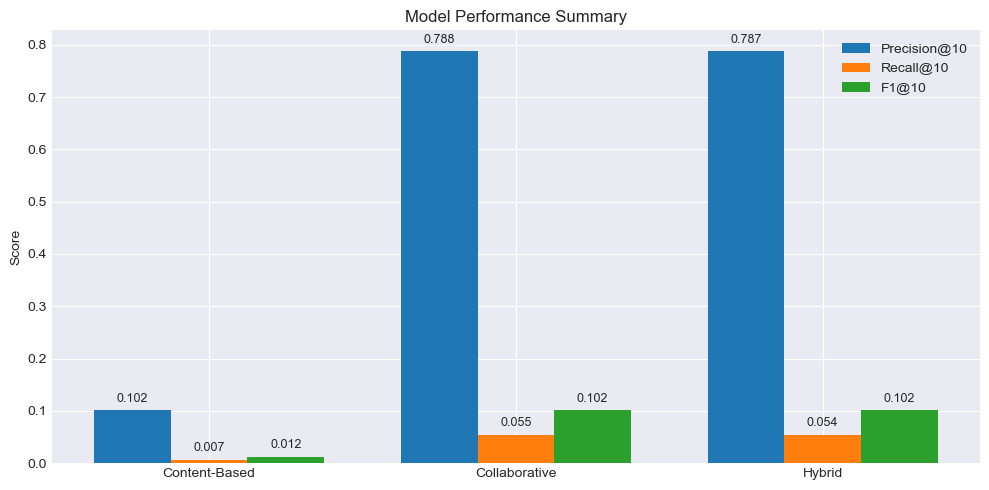

In [32]:
viz_df = results_df.copy()
viz_df["Model"] = viz_df["Model"].astype(str)

viz_df["Precision@10"] = viz_df["Precision@K"].astype(float)
viz_df["Recall@10"] = viz_df["Recall@K"].astype(float)
viz_df["F1@10"] = (2*viz_df["Precision@10"]*viz_df["Recall@10"]) / (viz_df["Precision@10"] + viz_df["Recall@10"] + 1e-9)

viz_df = viz_df[["Model","Precision@10","Recall@10","F1@10"]].copy()

# ===============================
# 1) Grouped bar chart: Precision/Recall/F1 (like your first)
# ===============================
models = viz_df["Model"].tolist()
x = np.arange(len(models))
w = 0.25

plt.figure(figsize=(10,5))
b1 = plt.bar(x - w, viz_df["Precision@10"], width=w, label="Precision@10")
b2 = plt.bar(x,      viz_df["Recall@10"],    width=w, label="Recall@10")
b3 = plt.bar(x + w,  viz_df["F1@10"],        width=w, label="F1@10")

plt.title("Model Performance Summary")
plt.ylabel("Score")
plt.xticks(x, models)

# value labels on bars
for bars in (b1, b2, b3):
    for bar in bars:
        h = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, h + 0.01, f"{h:.3f}", ha="center", va="bottom", fontsize=9)

plt.legend()
plt.tight_layout()
plt.show()

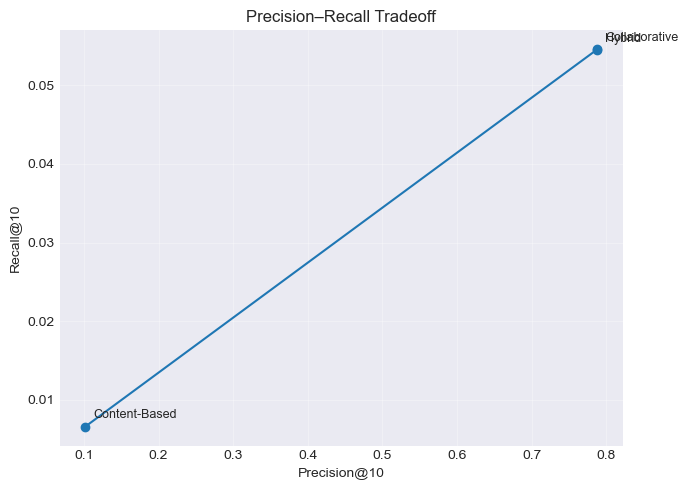

In [33]:
# ===============================
# 2) Precision–Recall tradeoff plot (like your middle)
# ===============================

plt.figure(figsize=(7,5))
plt.plot(viz_df["Precision@10"], viz_df["Recall@10"], marker="o")

for _, row in viz_df.iterrows():
    plt.annotate(row["Model"], (row["Precision@10"], row["Recall@10"]),
                 textcoords="offset points", xytext=(6,6), fontsize=9)

plt.title("Precision–Recall Tradeoff")
plt.xlabel("Precision@10")
plt.ylabel("Recall@10")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


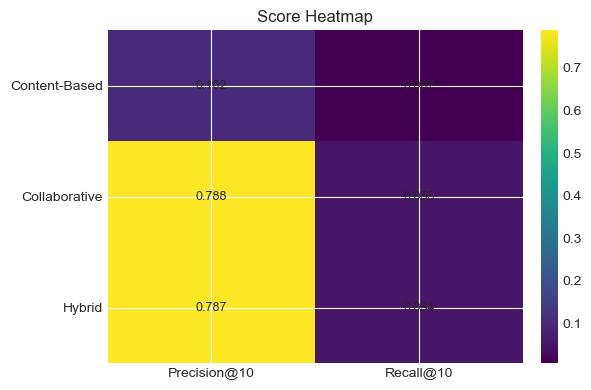

In [38]:

heat = viz_df.set_index("Model")[["Precision@10","Recall@10"]].copy()
mat = heat.values

plt.figure(figsize=(6,4))
im = plt.imshow(mat, aspect="auto", cmap="viridis")
plt.title("Score Heatmap")

plt.xticks(range(mat.shape[1]), heat.columns)
plt.yticks(range(mat.shape[0]), heat.index)

# annotate cells
for i in range(mat.shape[0]):
    for j in range(mat.shape[1]):
        plt.text(j, i, f"{mat[i,j]:.3f}", ha="center", va="center", fontsize=9)

plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()
